# Initialize

In [1]:
%load_ext autoreload
%autoreload 2

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn

import sys
sys.path.append('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders')

from AE.models import AE_0, ProgressiveAE
from AE.datasets import MNISTDigit2Dataset

from AE.depth_utils import calc_hfm_kld_with_optimal_g, compute_bottleneck_neurons_activ_freq, compute_emp_states_dict_gauged, compute_bottleneck_neurons_activ_freq_gauged
from AE.plotter_functions import visualize_bottleneck_neurons, plot_KLs_vs_hidden_layers, datasets_dicts_comparison

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Utilizzo Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Utilizzo NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Utilizzo la CPU")

device = torch.device("cpu")  # Fallback to CPU if no GPU is available

SEED = 42
torch.manual_seed(SEED)


Utilizzo Apple Silicon GPU (MPS)



# Datasets


In [2]:
batch_size = 64

## MNIST
train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



## ExtendedMNIST

train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )


## 2MNIST

dataset_2MNIST_train = MNISTDigit2Dataset(train=True, download=True, target_size=60000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
train_loader_2MNIST = DataLoader(dataset_2MNIST_train, batch_size=batch_size, shuffle=True)

batch_images, batch_labels = next(iter(train_loader_2MNIST))
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")

print("\n––––––––––––––––––––––––––––––––––––––––––––––––––––––\n")

dataset_2MNIST_val = MNISTDigit2Dataset(train=False, download=True, target_size=10000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")
val_loader_2MNIST = DataLoader(dataset_2MNIST_val, batch_size=batch_size, shuffle=True)

print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")




#-------------------------------------------------------------------


datasets = ["MNIST", "EMNIST", "2MNIST"]
train_loaders = {
    "MNIST": train_loader_MNIST,
    "EMNIST": train_loader_EMNIST,
    "2MNIST": train_loader_2MNIST
}
val_loaders = {
    "MNIST": val_loader_MNIST,
    "EMNIST": val_loader_EMNIST,
    "2MNIST": val_loader_2MNIST
}


Found 5958 original samples of digit '2'
Generated 60000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True

––––––––––––––––––––––––––––––––––––––––––––––––––––––

Found 1032 original samples of digit '2'
Generated 10000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
All labels are 2: True
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True


In [ ]:

## FashionMNIST

train_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )




## OTHERS


In [ ]:
from AE.datasets import Dataset_HFM, Dataset_pureHFM

batch_size = 64


## train over pureHFM

dataset_HFM_train = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_pureHFM = DataLoader(
    dataset_HFM_train,
    batch_size= batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_pureHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size= batch_size,
    shuffle=False
)
## train over expandedHFM
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM = DataLoader(
    dataset_HFM_train,
    batch_size= batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size= batch_size,
    shuffle=False
)
## train over expandedHFM 32-1024
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_train,
    batch_size= batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size= batch_size,
    shuffle=False
)


# ----- Simultaneous train -----

## HFM KLD

### 20 features

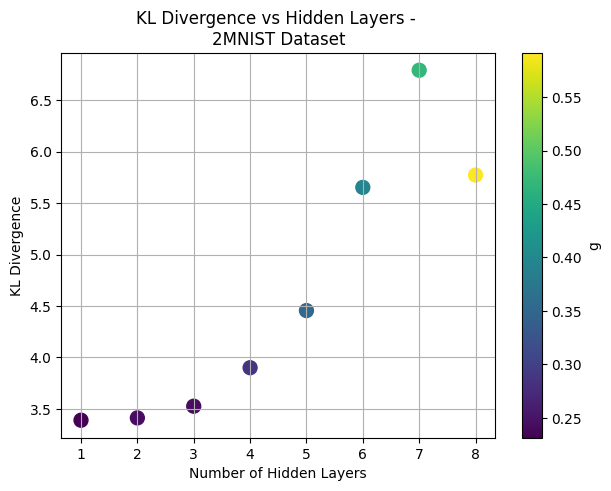

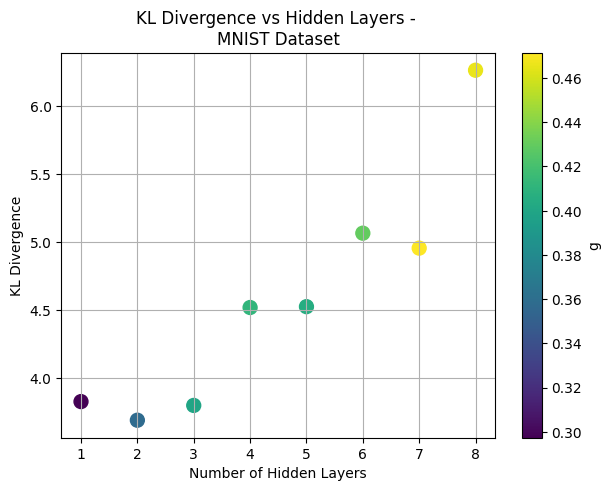

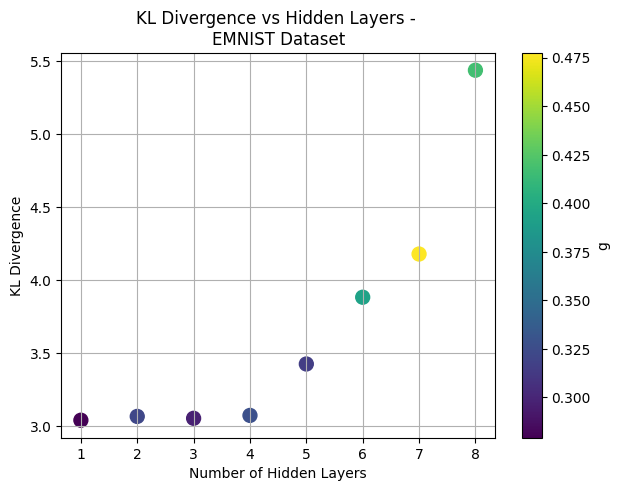

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




train_loader = train_loader_2MNIST
val_loader = val_loader_2MNIST
input_dim = 28 * 28

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=8, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_8hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["2MNIST"], gs_dict["2MNIST"], "2MNIST")


#------------------------------------------------------

train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 28 * 28

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=8, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_8hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["MNIST"], gs_dict["MNIST"], "MNIST")


#------------------------------------------------------


train_loader = train_loader_EMNIST
val_loader = val_loader_EMNIST
input_dim = 28 * 28

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=8, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_8hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["EMNIST"], gs_dict["EMNIST"], "EMNIST")




In [ ]:
import pickle

with open('KLs_dict.pkl', 'wb') as f:
    pickle.dump(KLs_dict, f)



In [7]:
import pickle
with open('KLs_dict.pkl', 'rb') as f:
    KLs_dict = pickle.load(f)

In [6]:
import copy
KLs_dict = copy.deepcopy(KLs_dict)

KLs_dict["2MNIST"].pop()
KLs_dict["MNIST"].pop()
KLs_dict["EMNIST"].pop()

NameError: name 'KLs_dict' is not defined

In [57]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

### 6 features

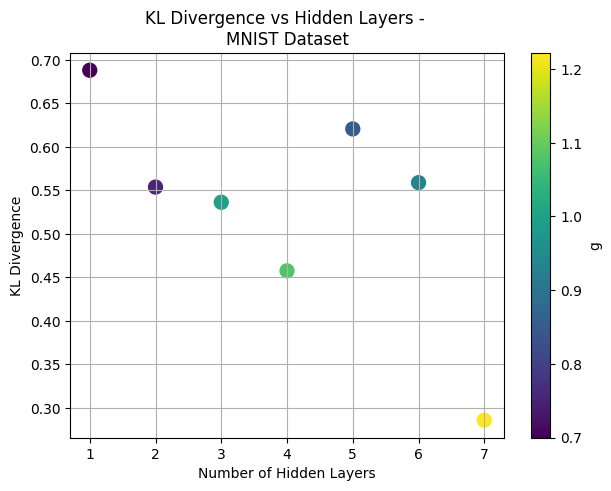

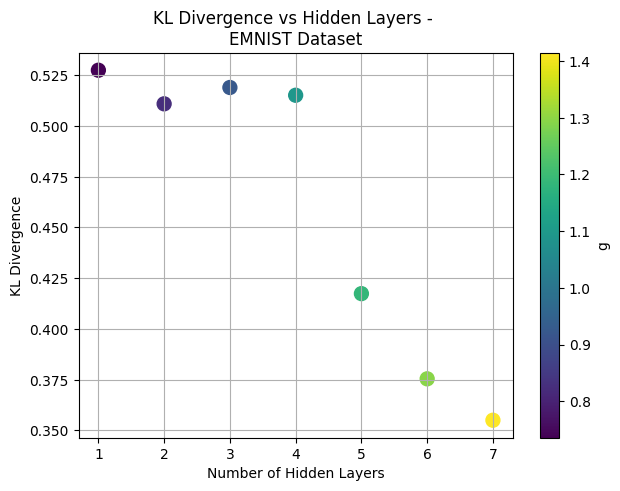

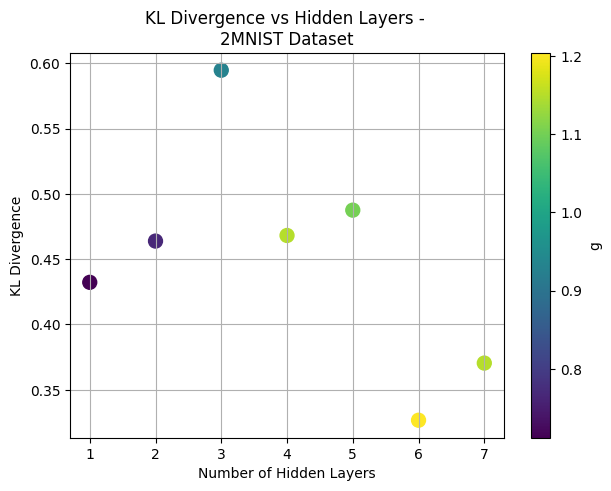

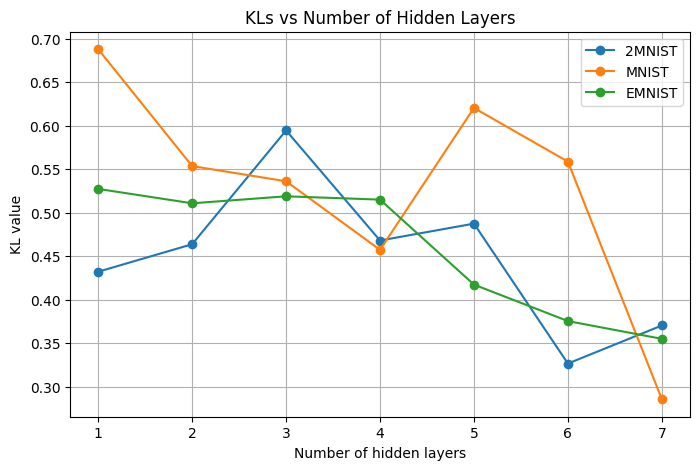

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,8):    # 1-7 hl
        latent_dim = 6
        decrease_rate = 0.6
        decrease_rate_str = "06"
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)

### 8 features

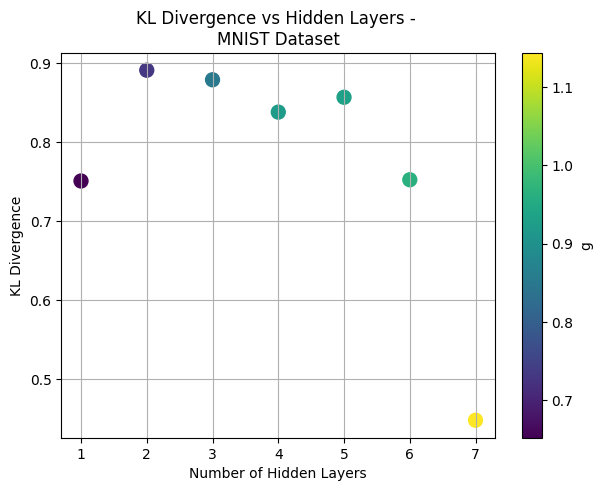

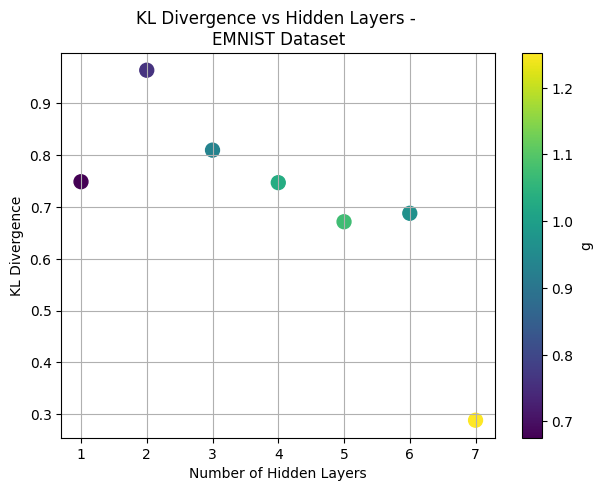

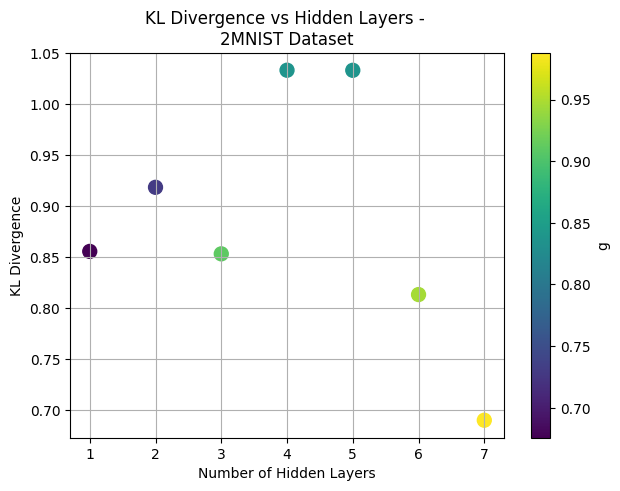

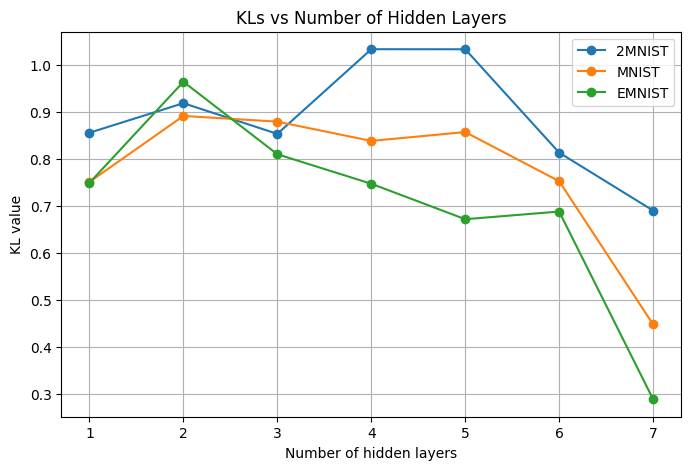

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,8):    # 1-7 hl
        latent_dim = 8
        decrease_rate = 0.6
        decrease_rate_str = "06"
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)

### 10 features

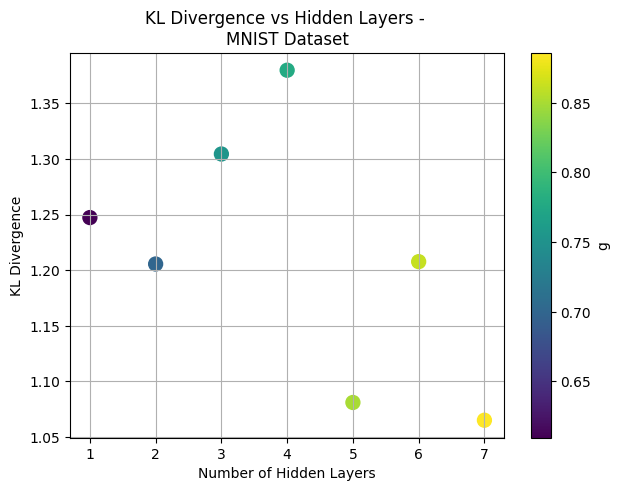

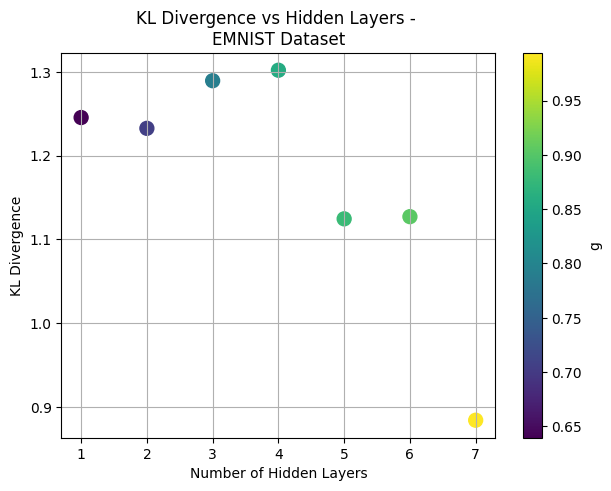

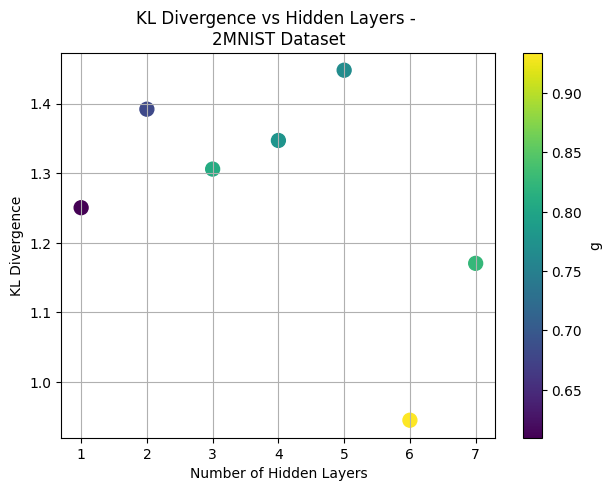

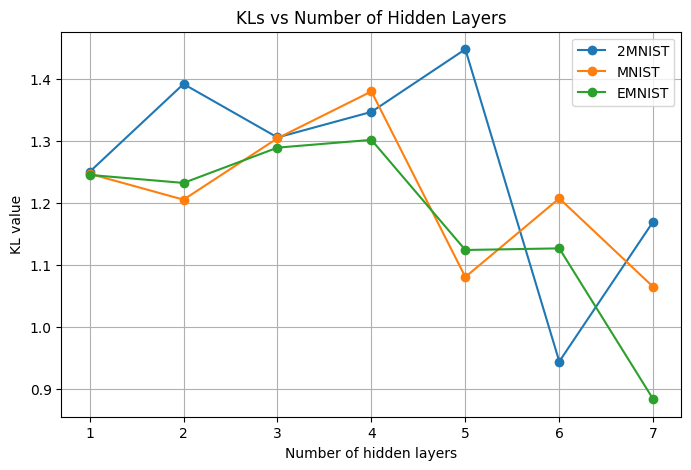

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,8):    # 1-7 hl
        latent_dim = 10
        decrease_rate = 0.6
        decrease_rate_str = "06"
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

    save_dir = f"../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{threshold_for_binarization}"
    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)

### 2_M_E_MNIST

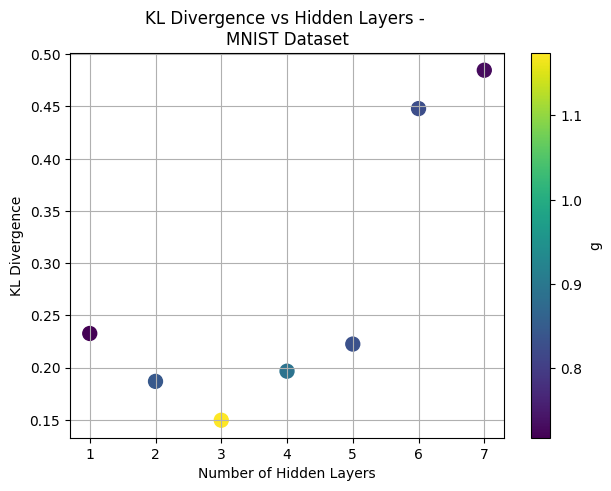

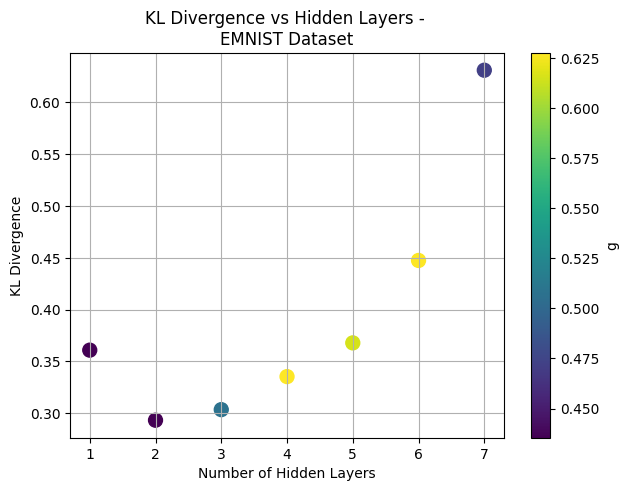

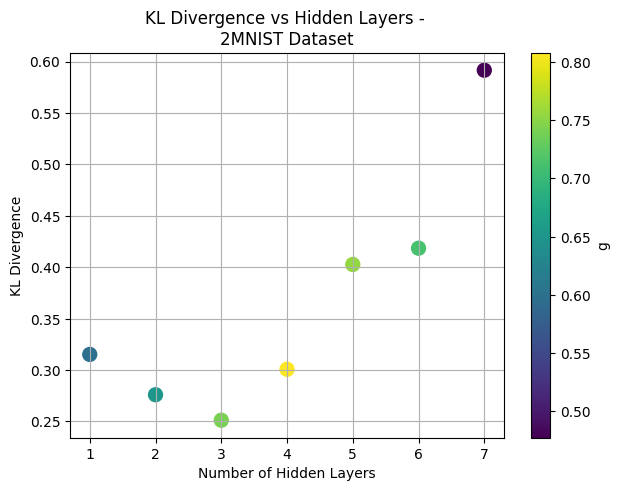

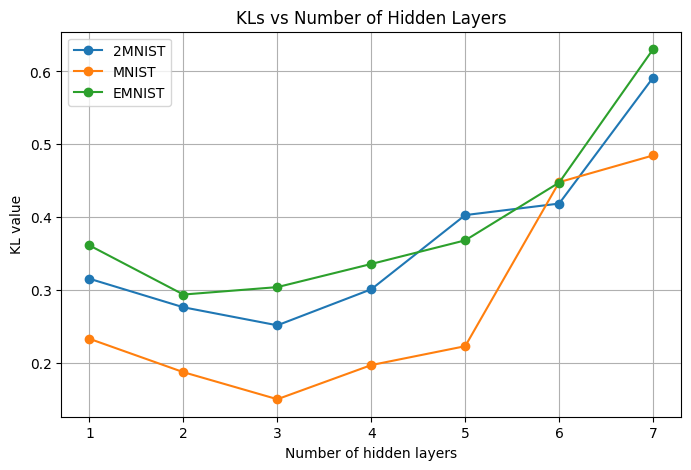

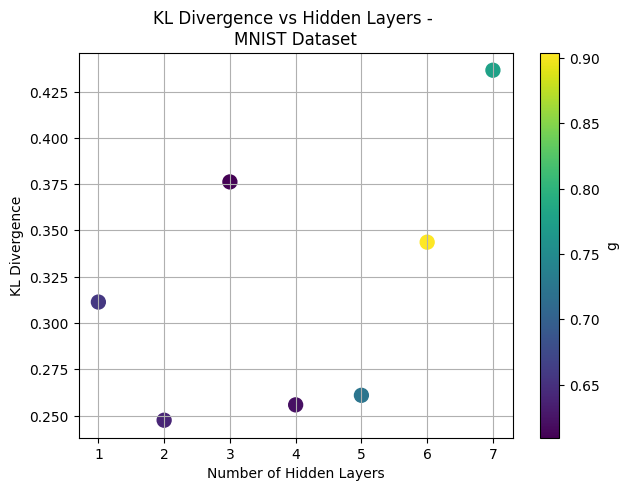

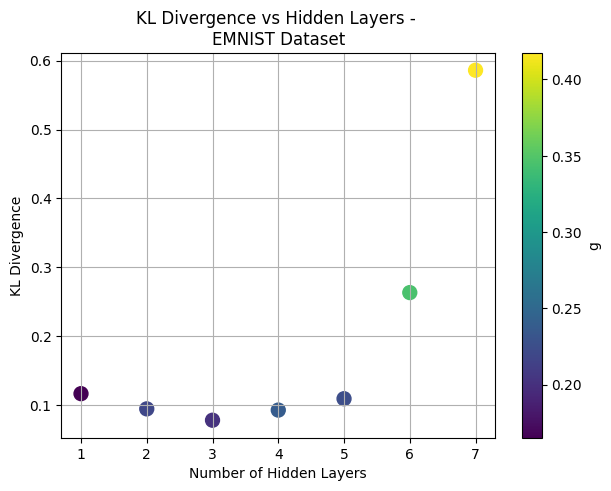

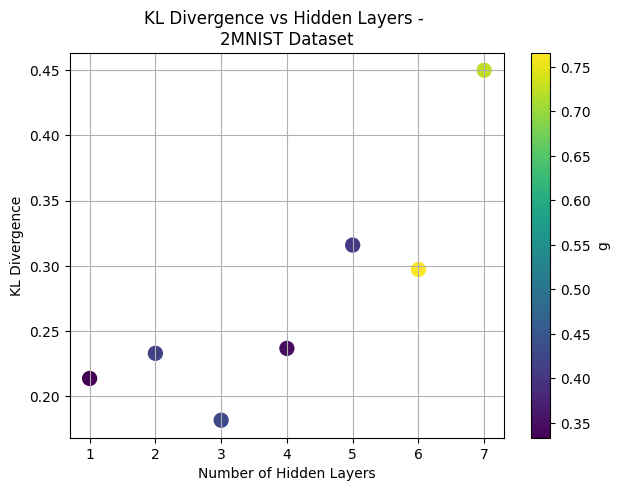

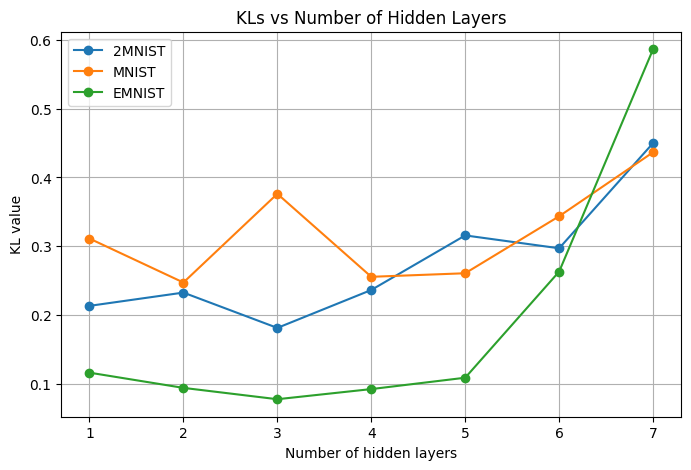

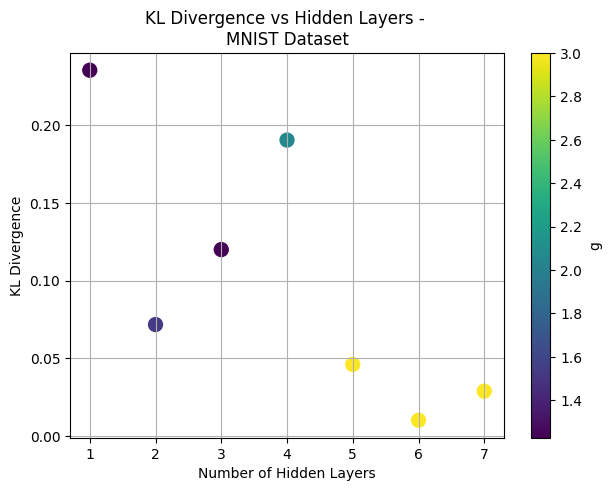

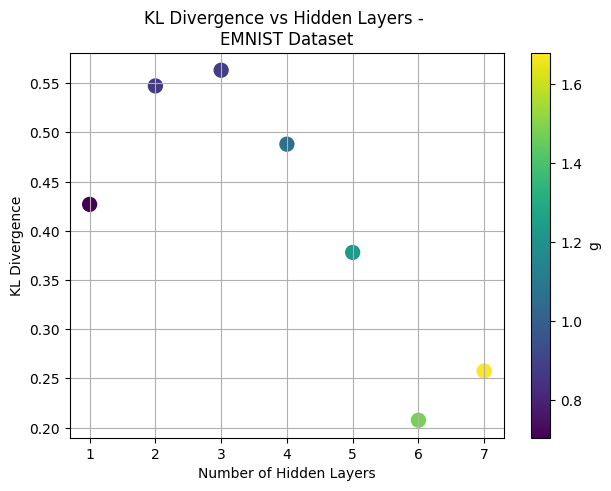

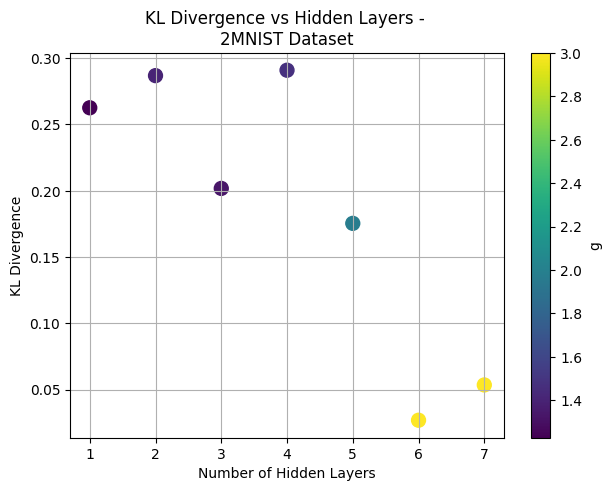

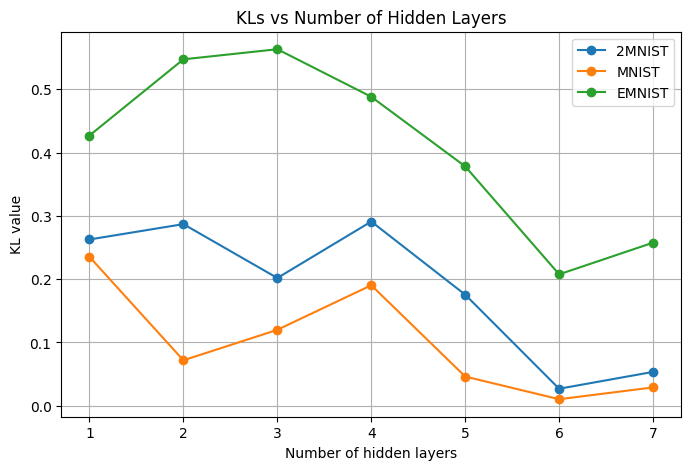

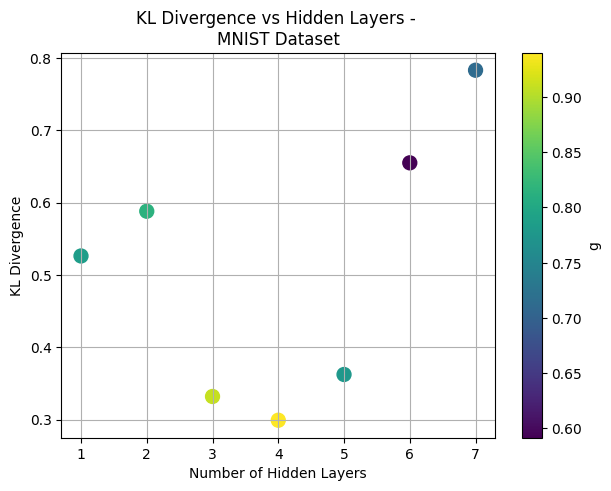

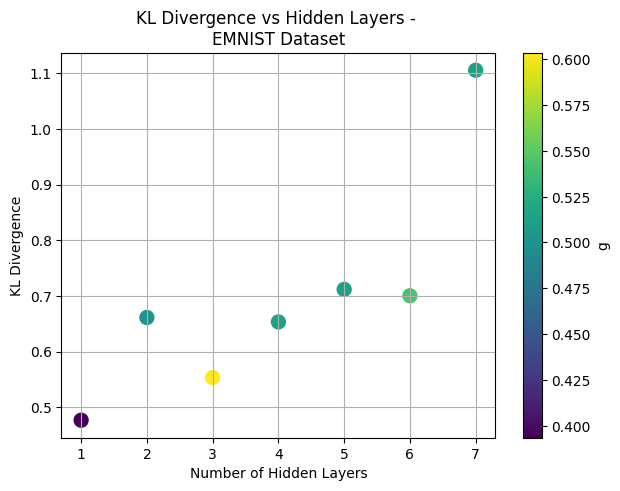

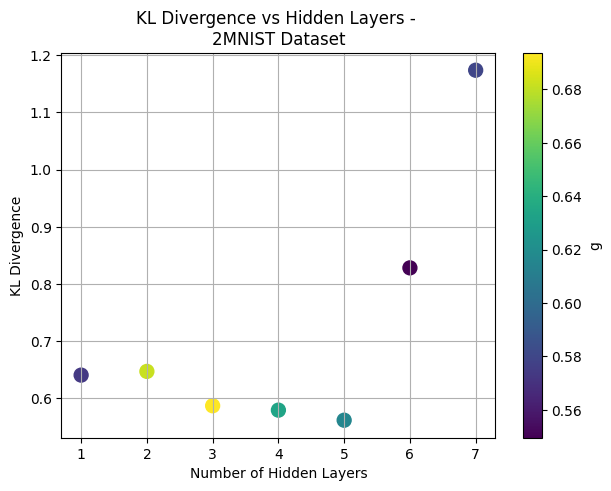

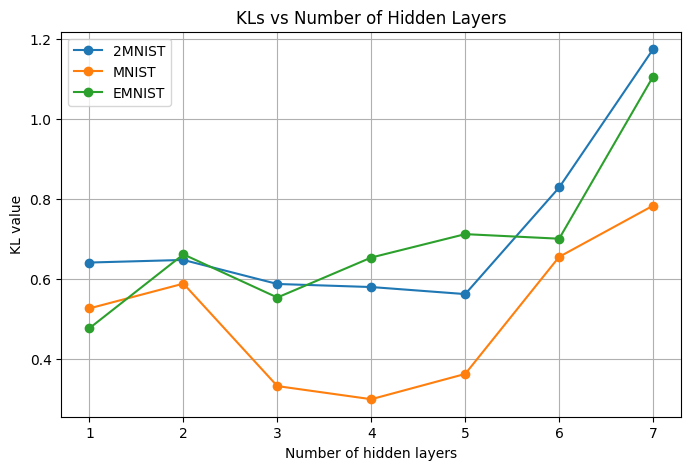

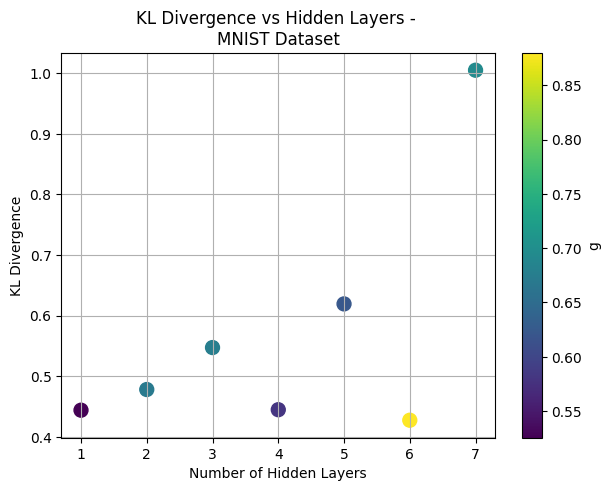

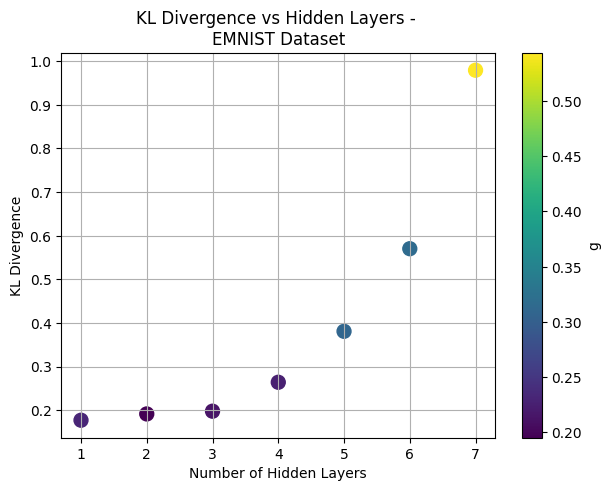

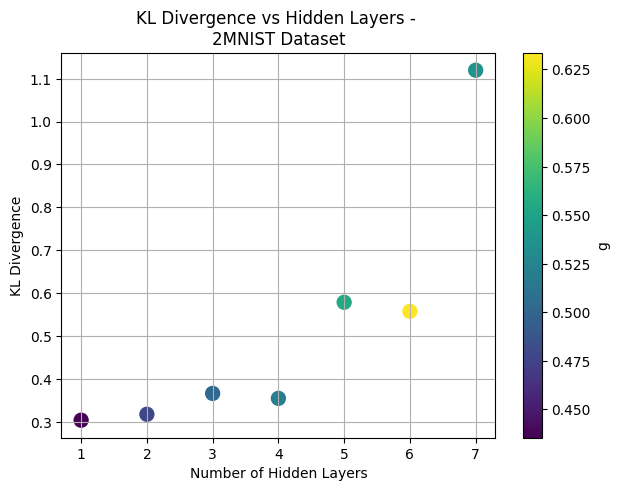

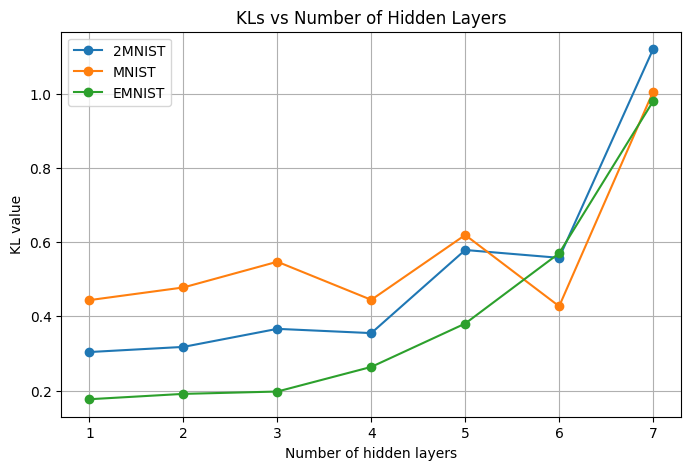

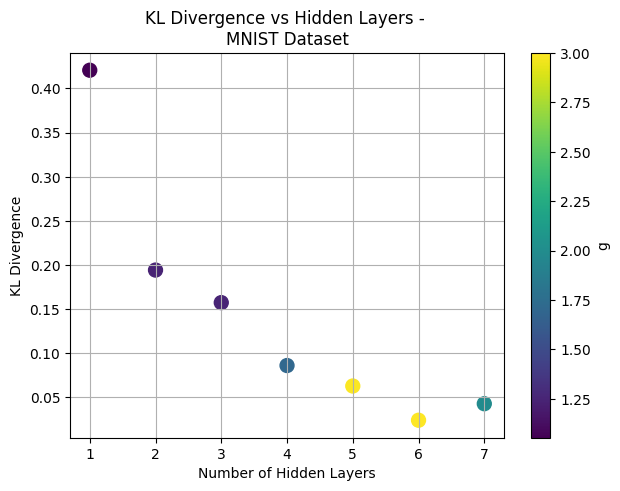

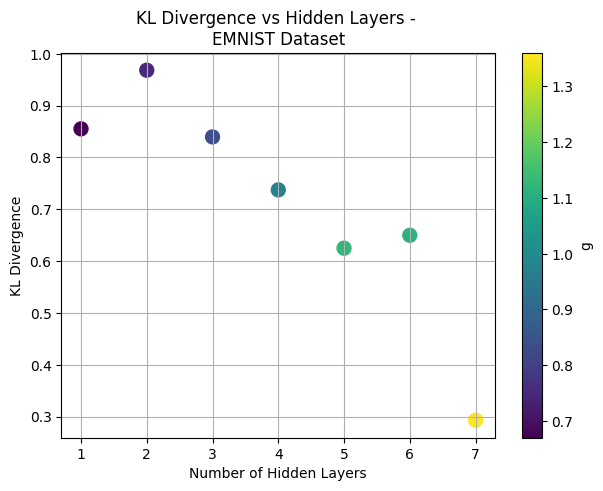

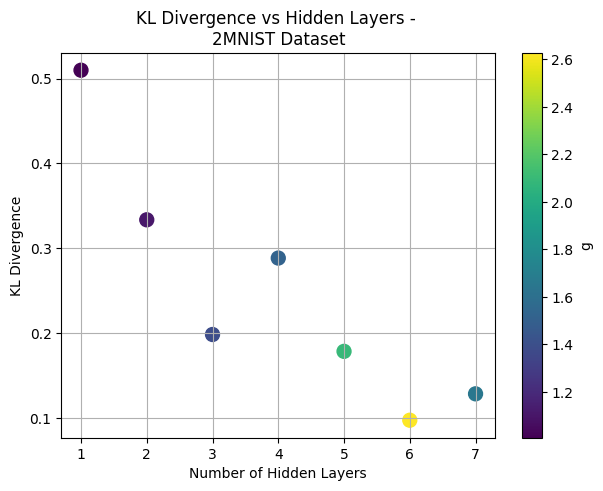

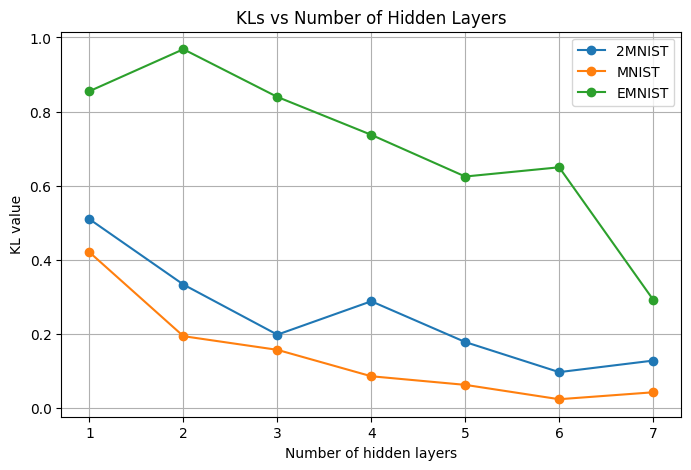

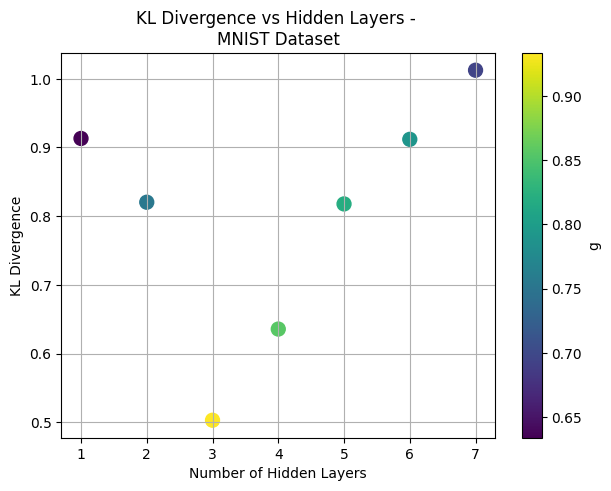

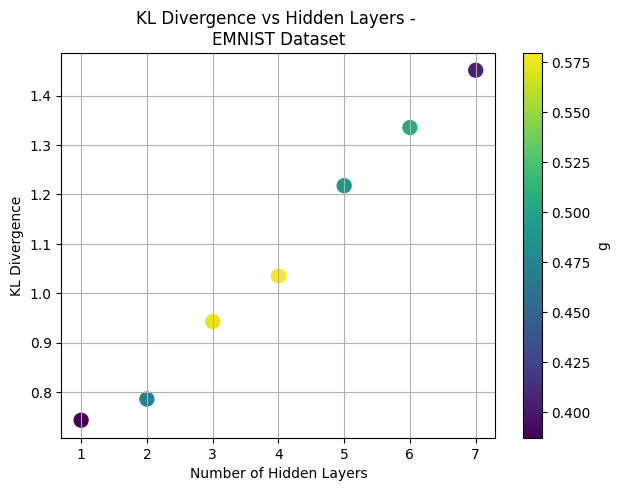

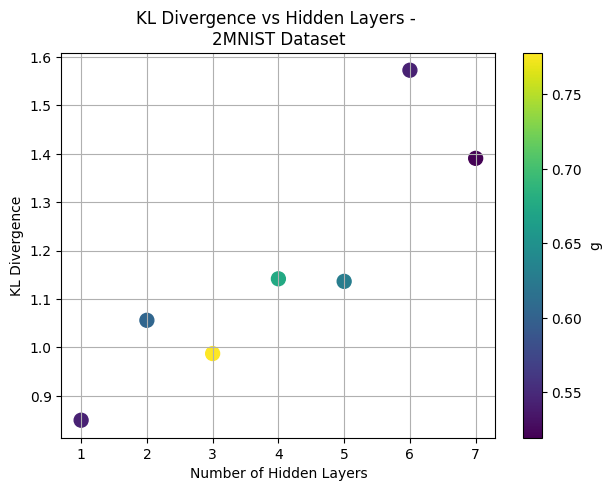

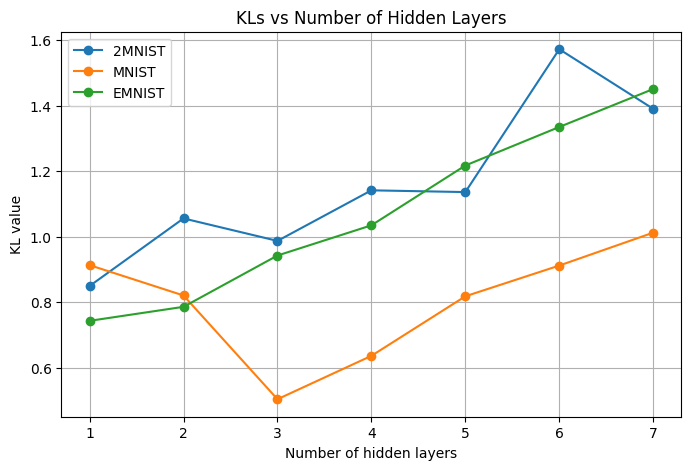

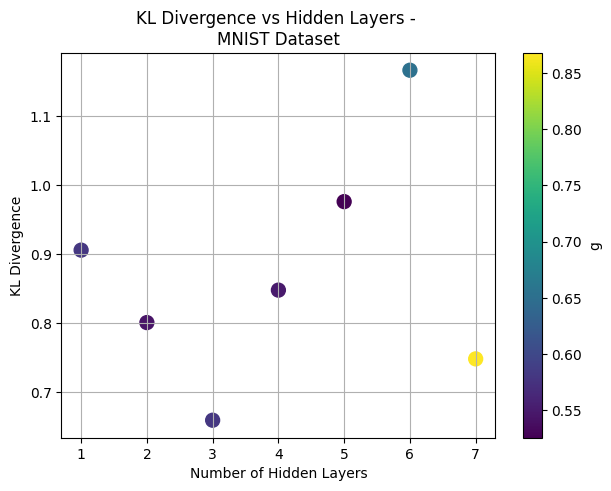

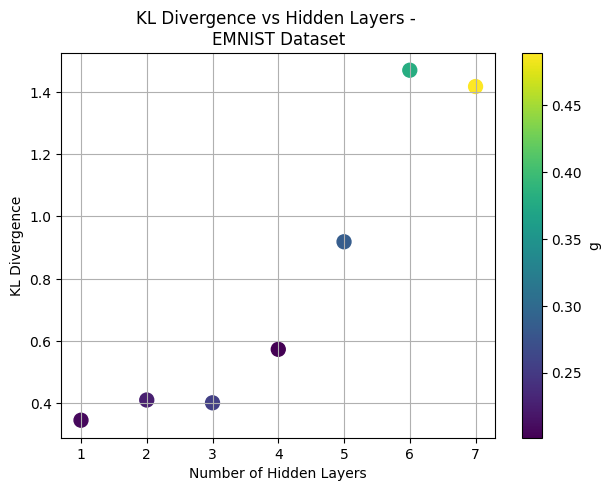

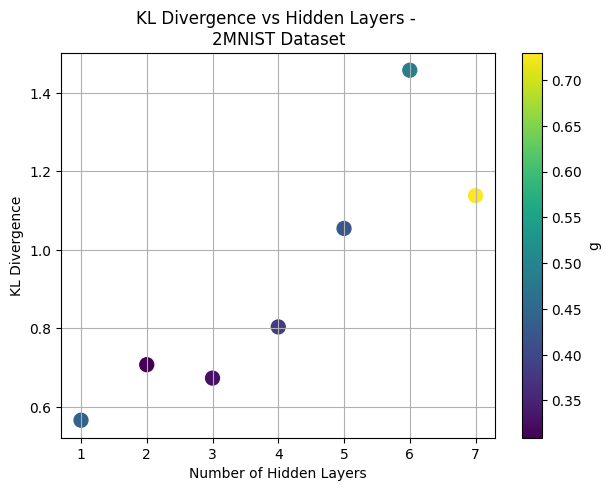

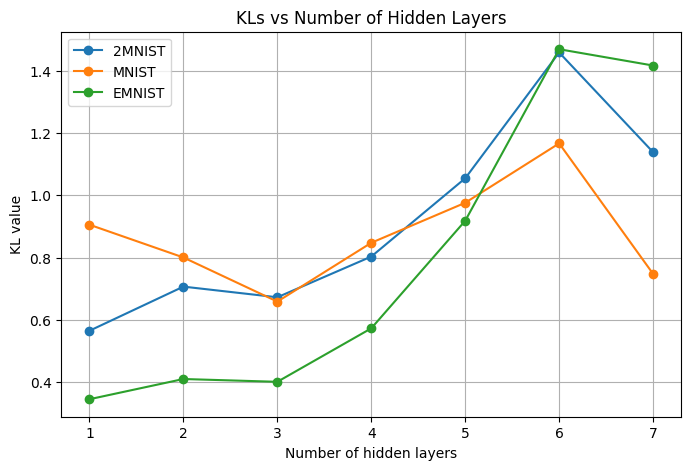

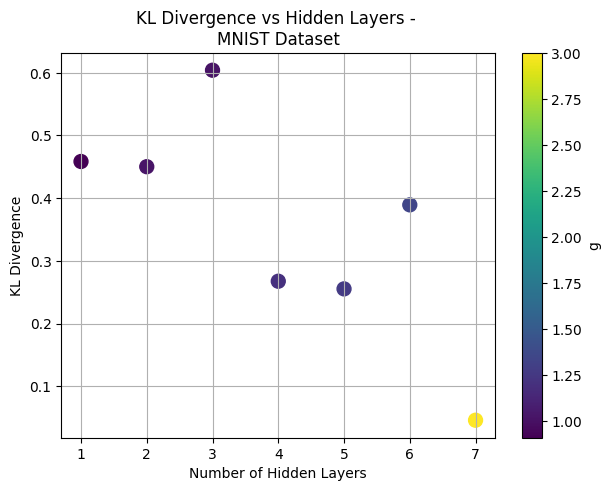

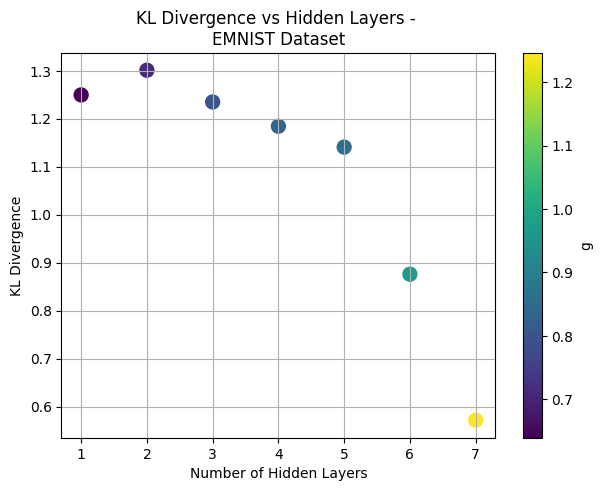

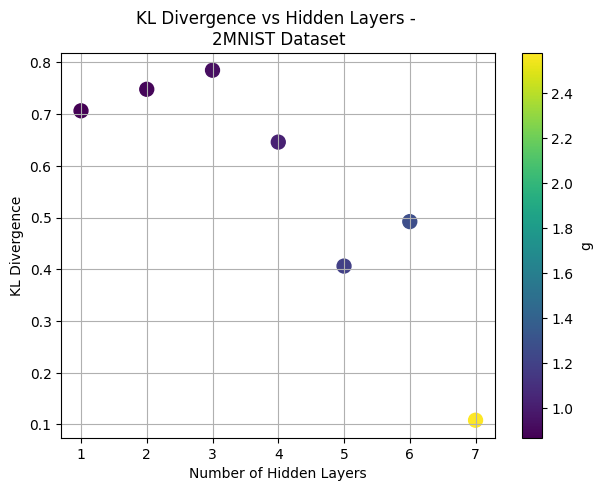

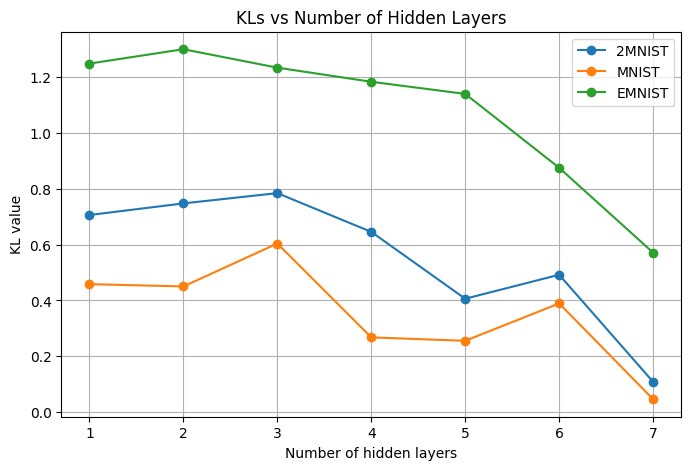

In [6]:
for latent_dim in (6,8,10):
    for binarize_threshold in (0.3, 0.5, 0.8):

        KLs_dict = {
            '2MNIST': [],
            'MNIST': [],
            'EMNIST': []}

        gs_dict = {
            '2MNIST': [],
            'MNIST': [],
            'EMNIST': []}  

        for dataset in datasets:
            for num_hidden_layers in range(1,8):    # 1-7 hl

                decrease_rate = 0.6
                decrease_rate_str = "06"
                train_loader = train_loaders[dataset]
                val_loader = val_loaders[dataset]
                input_dim = 28 * 28

                my_model = AE_0(
                    input_dim=input_dim,
                    latent_dim=latent_dim,
                    decrease_rate=decrease_rate,
                    device=device,
                    hidden_layers=num_hidden_layers
                ).to(device)
                model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                my_model.load_state_dict(torch.load(model_path, map_location=device))

                KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, binarize_threshold=binarize_threshold)
                
                KLs_dict[dataset].append(KL)
                gs_dict[dataset].append(g)

            save_dir = f"../Images/2_M_E_MNIST/simultaneous train/{latent_dim}features/thresh_for_bin_{binarize_threshold}"
            plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

        datasets_dicts_comparison(KLs_dict, save_dir)

## Visualize 3hl neurons

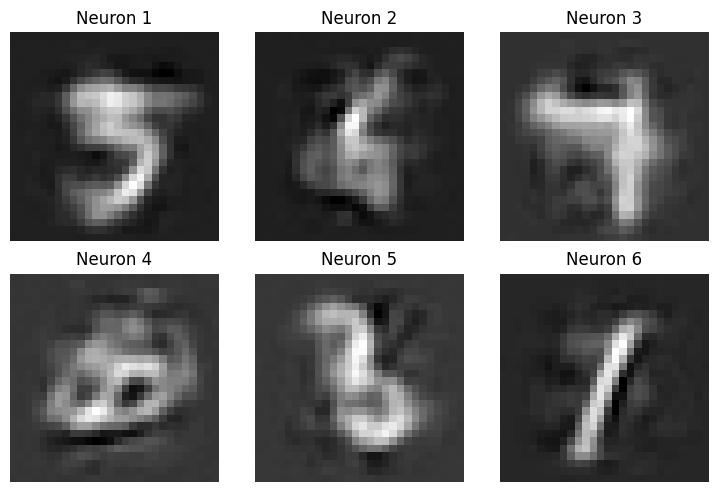

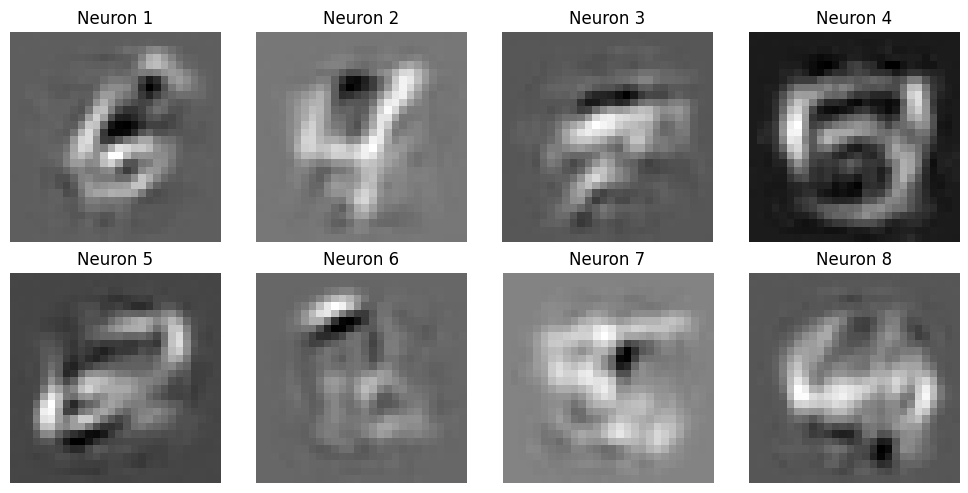

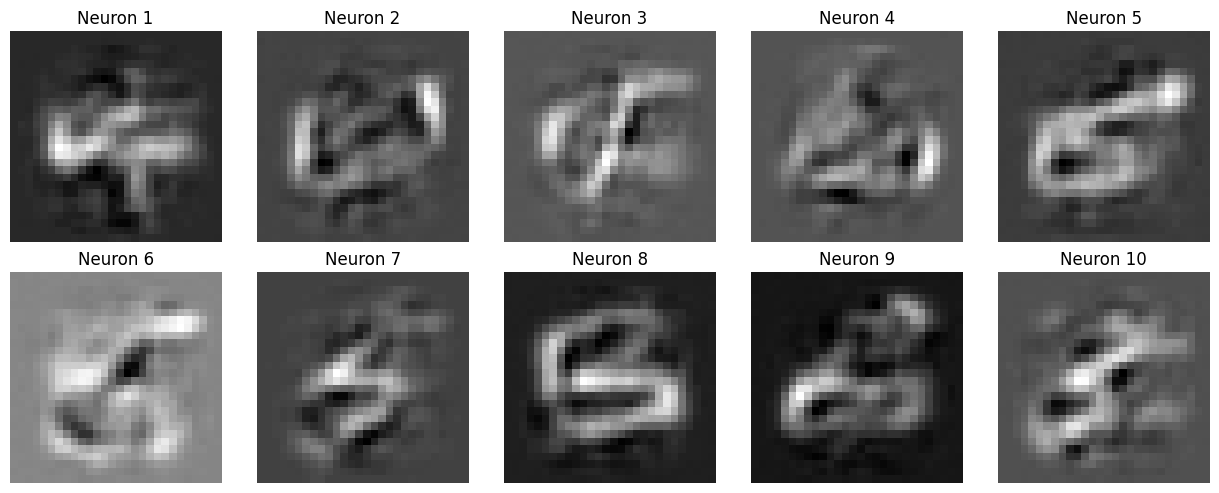

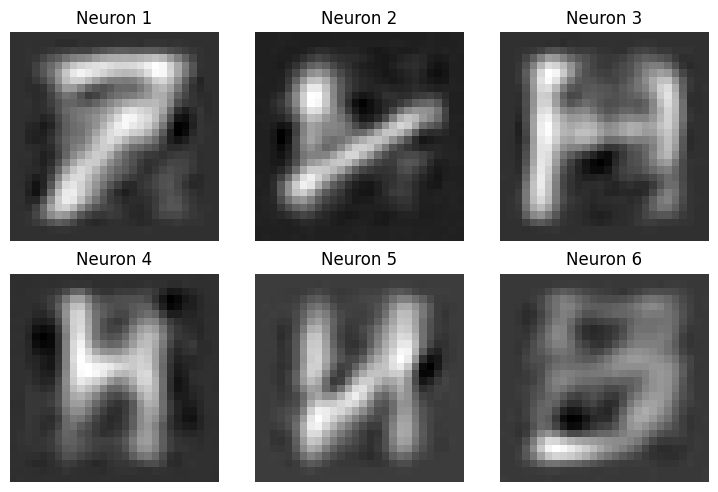

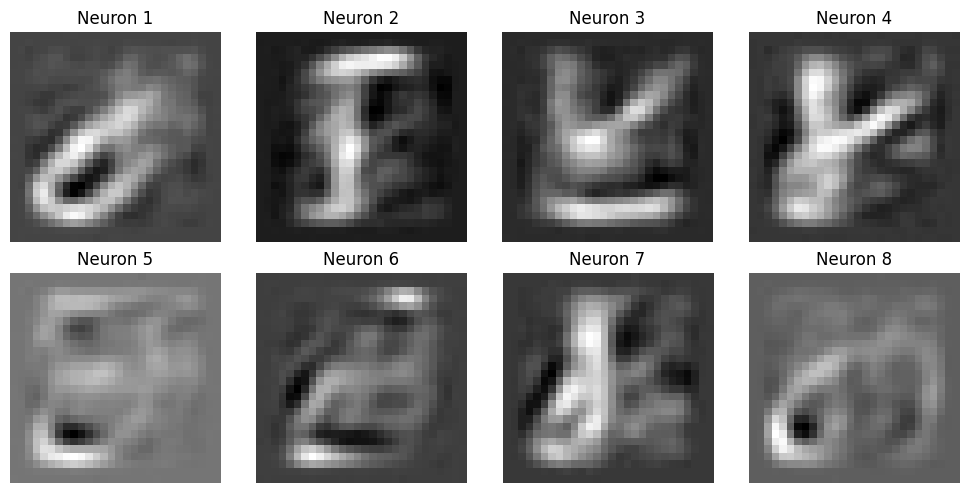

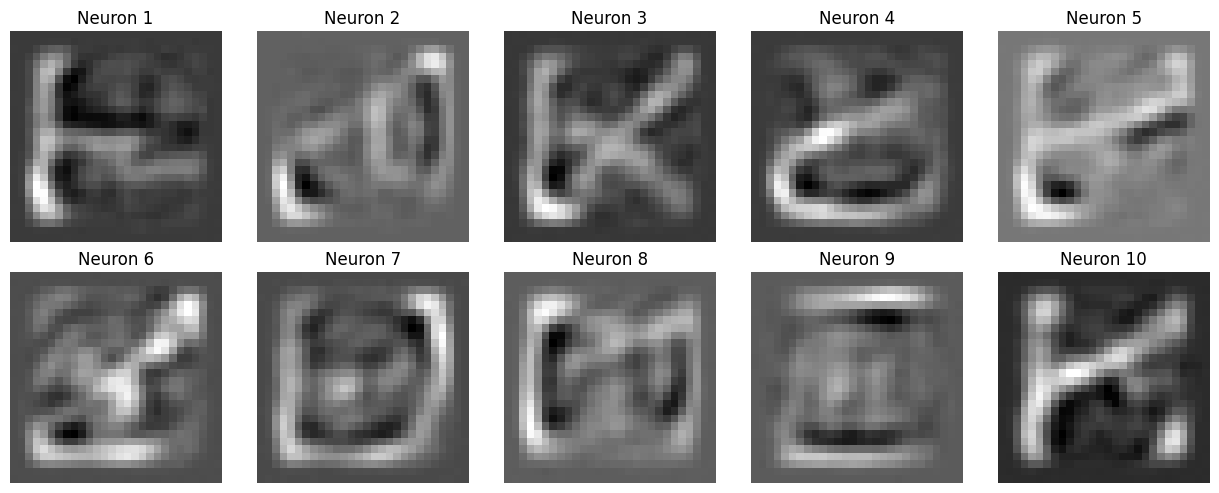

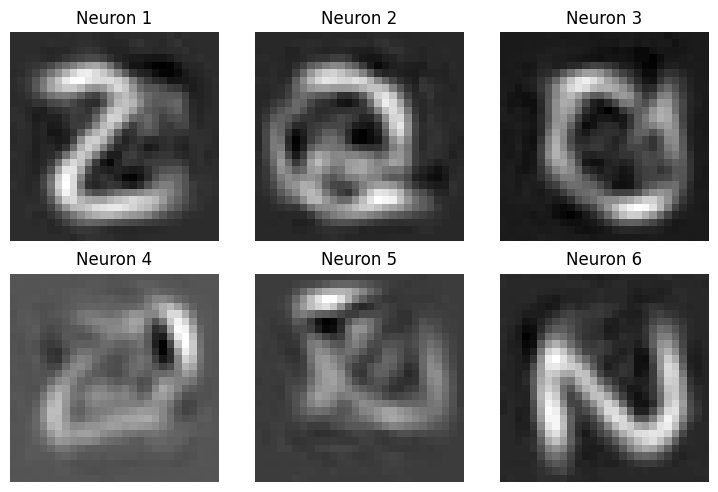

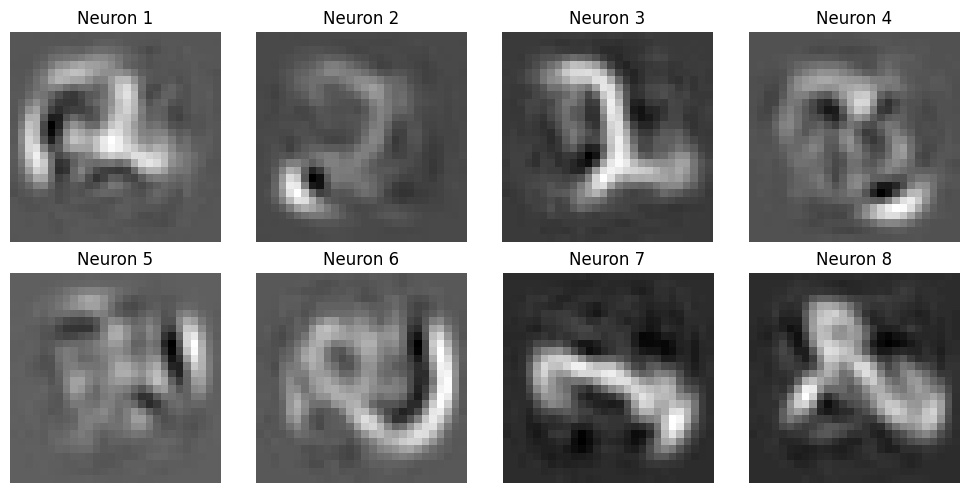

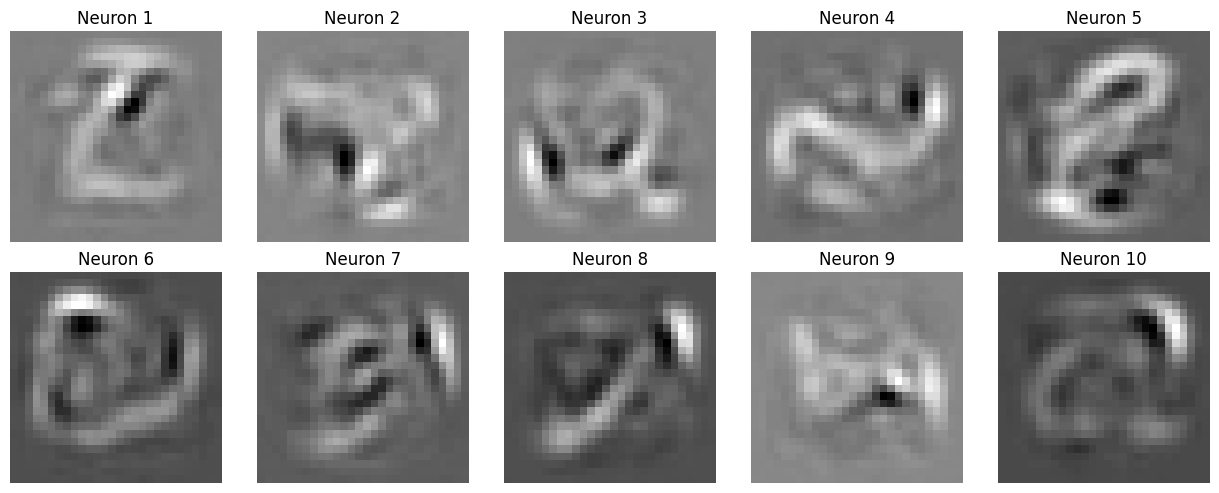

In [3]:
for dataset in datasets:
    
    for latent_dim in (6,8,10):
        num_hidden_layers = 3
        decrease_rate = 0.6
        decrease_rate_str = "06"
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28


        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))




        save_dir = f"../Images/{latent_dim}features/simultaneous train/latent neurons"

        visualize_bottleneck_neurons(my_model, device, save_dir=save_dir, file_name=dataset)

### 2_M_E_MNIST

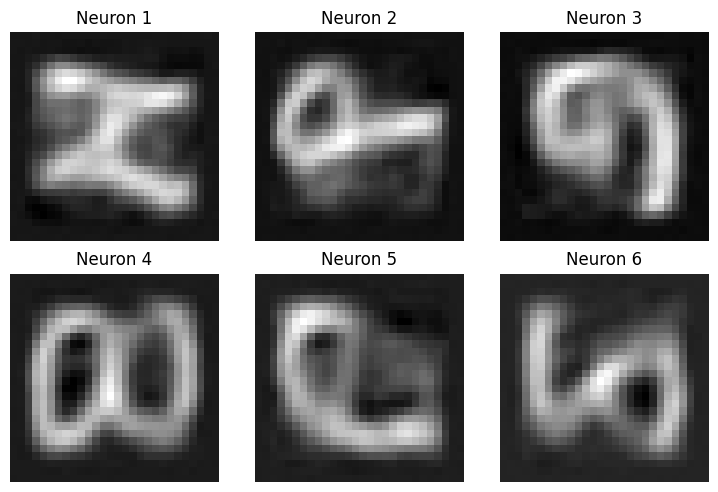

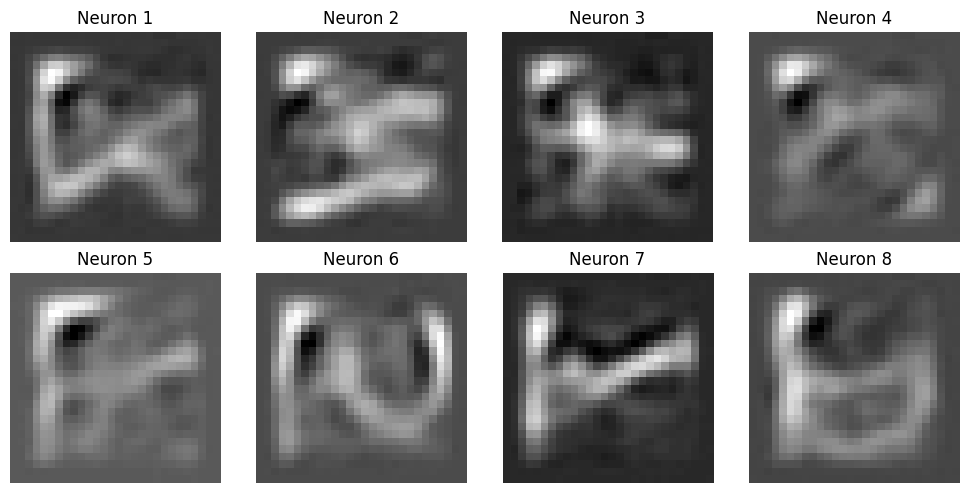

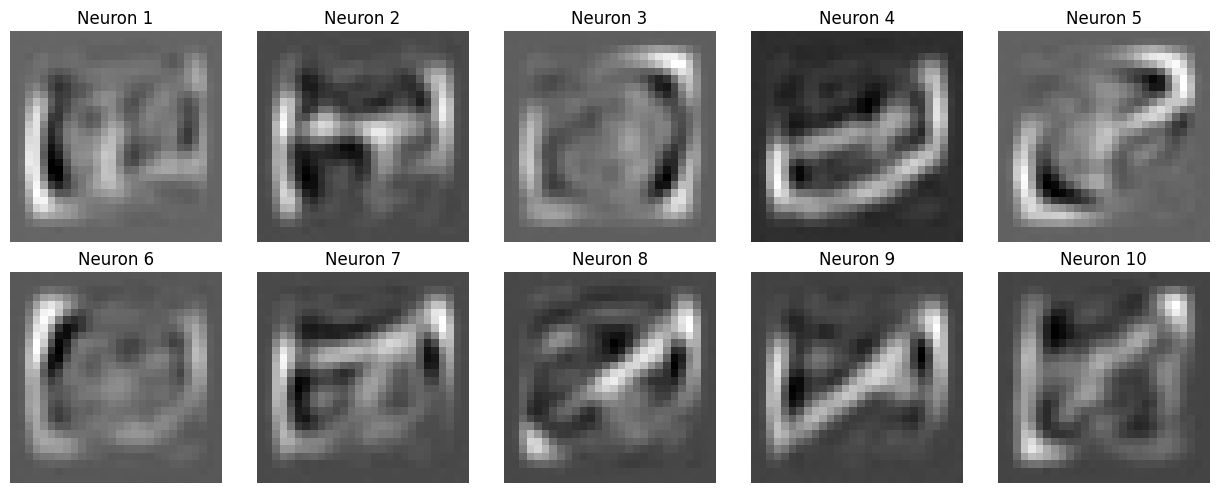

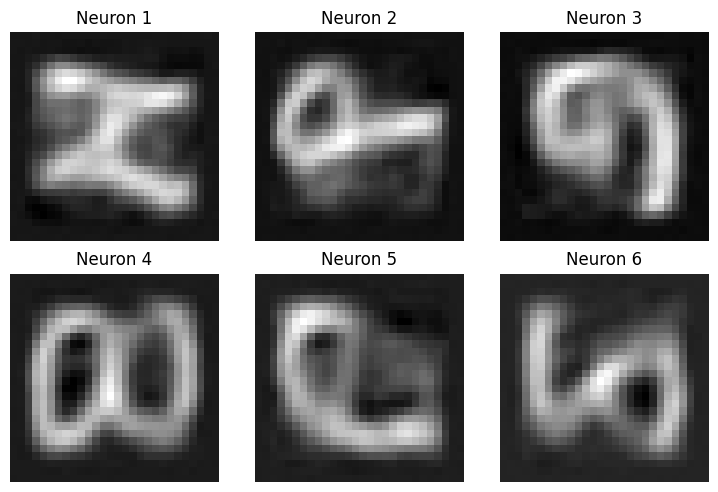

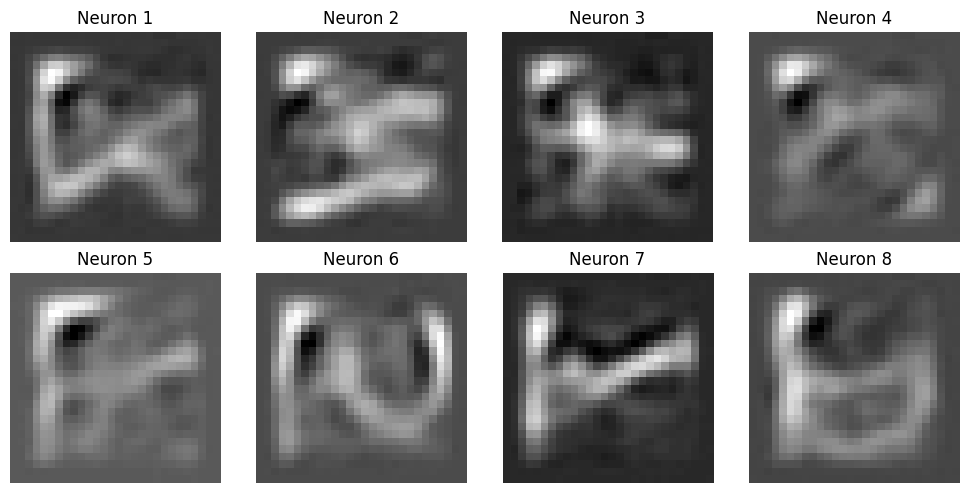

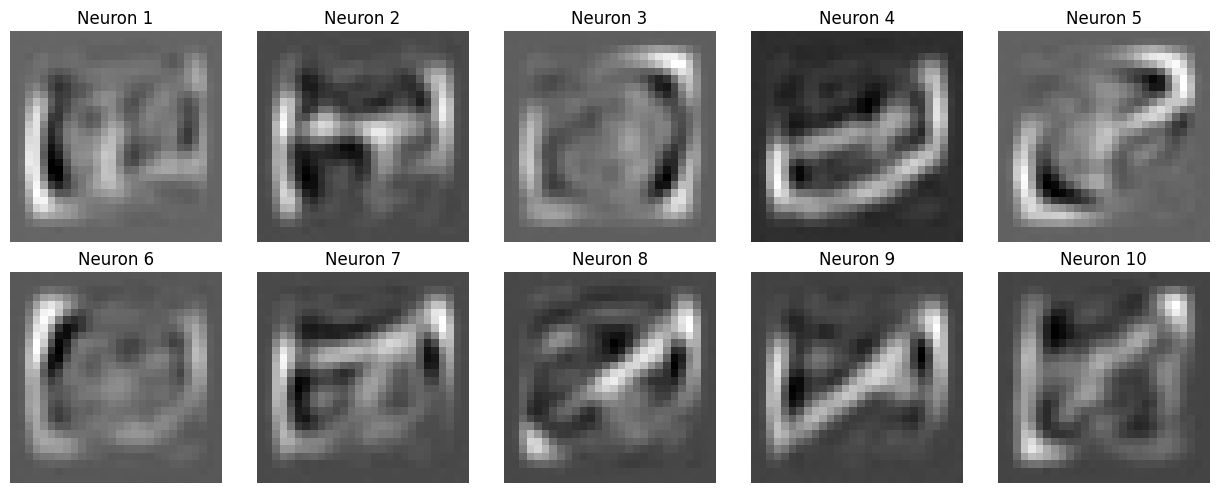

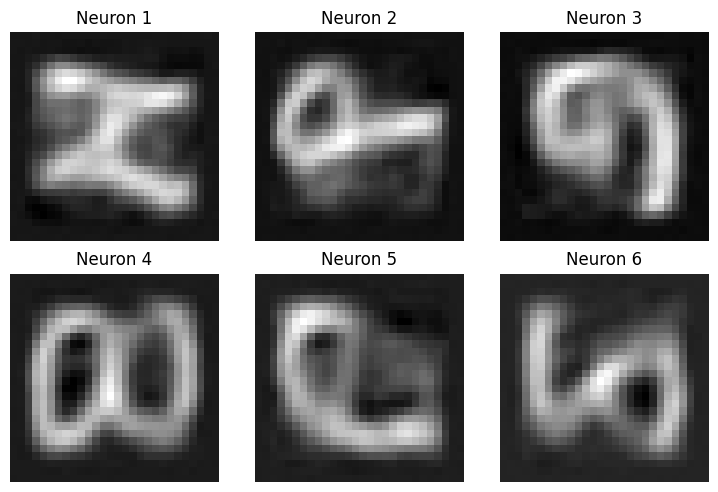

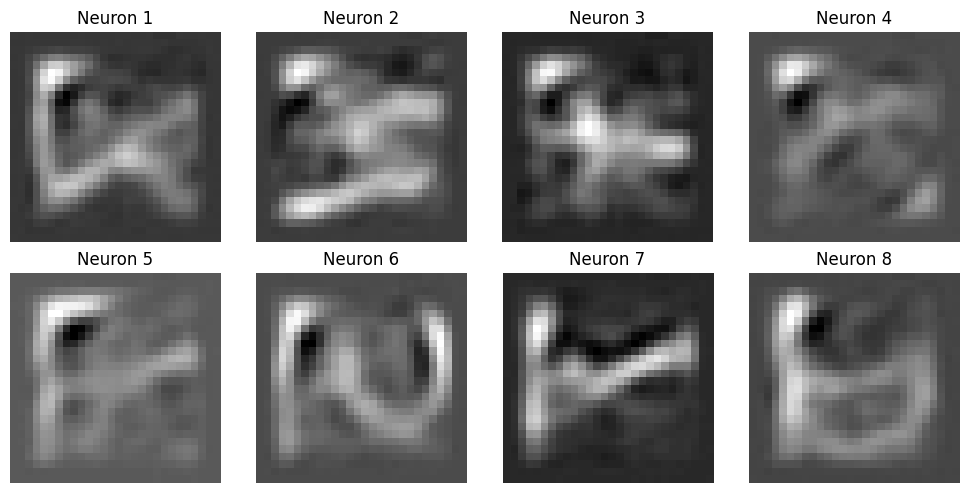

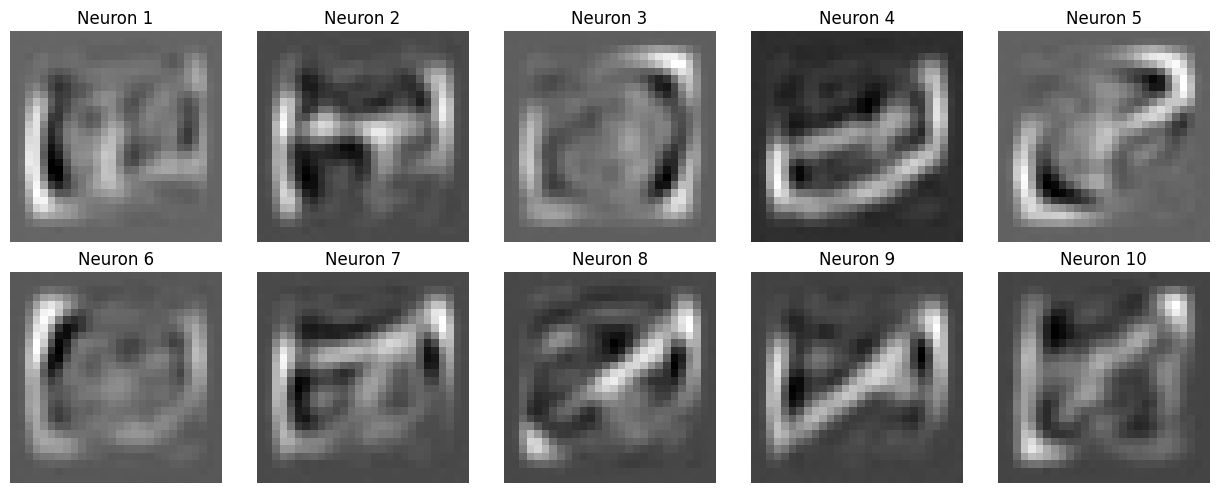

In [8]:
for dataset in datasets:
    
    for latent_dim in (6,8,10):
        num_hidden_layers = 3
        decrease_rate = 0.6
        decrease_rate_str = "06"
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28


        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))




        save_dir = f"../Images/2_M_E_MNIST/simultaneous train/{latent_dim}features/latent neurons"

        visualize_bottleneck_neurons(my_model, device, save_dir=save_dir, file_name=dataset)

## Bottleneck neurons activation frequencies

### Not gagued

In [ ]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8):

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')

### Gauged

In [4]:
for latent_dim in (6, 8, 10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations_gauged.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))
                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq_gauged(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')

### 2_M_E_MNIST

In [5]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        save_dir = f"../Images/2_M_E_MNIST/simultaneous train/{latent_dim}features/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8):

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')

In [6]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        save_dir = f"../Images/2_M_E_MNIST/simultaneous train/{latent_dim}features/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations_gauged.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8):

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq_gauged(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')

## Bottleneck weights 

In [ ]:
# Weights mean absolute value

with torch.no_grad():
    for latent_dim in (6,8,10):
        with open(f'../Images/{latent_dim}features/simultaneous train/weights_mean_abs_value.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    weights_in = my_model.encoder[-2].weight.data.abs().mean(dim=1).tolist()
                    formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                    f.write("In " + formatted_weights_in + '\n\n')

                    weights_out = my_model.decoder[0].weight.data.abs().mean(dim=0).tolist()
                    formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                    f.write("      Out " + formatted_weights_out + '\n\n')

In [ ]:
# Weights mean

with torch.no_grad():
    for latent_dim in (6,8,10):
        with open(f'../Images/{latent_dim}features/simultaneous train/weights_mean.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    weights_in = my_model.encoder[-2].weight.data.mean(dim=1).tolist()
                    formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                    f.write("In " + formatted_weights_in + '\n\n')

                    weights_out = my_model.decoder[0].weight.data.mean(dim=0).tolist()
                    formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                    f.write("      Out " + formatted_weights_out + '\n\n')

### 2_M_E_MNIST

In [7]:
# Weights mean absolute value

with torch.no_grad():
    for latent_dim in (6,8,10):
        save_dir = f"../Images/2_M_E_MNIST/simultaneous train/{latent_dim}features/weight_mean_abs_value.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    weights_in = my_model.encoder[-2].weight.data.abs().mean(dim=1).tolist()
                    formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                    f.write("In " + formatted_weights_in + '\n\n')

                    weights_out = my_model.decoder[0].weight.data.abs().mean(dim=0).tolist()
                    formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                    f.write("      Out " + formatted_weights_out + '\n\n')

## Gauge permutations

In [8]:
for latent_dim in (6,8,10):
    for binarize_threshold in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{binarize_threshold}/gauge_permutations.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8): # from 1 to 7

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    emp_states_dict_guaged, perm = compute_emp_states_dict_gauged(my_model, train_loader, binarize_threshold=binarize_threshold, return_perm=True)
                
                    f.write(str(perm) + '\n\n')

### 2_M_E_MNIST

In [12]:
for latent_dim in (6,8,10):
    for binarize_threshold in (0.3, 0.5, 0.8):
        save_dir = f"../Images/2_M_E_MNIST/simultaneous train/{latent_dim}features/thresh_for_bin_{binarize_threshold}/gauge_permutations.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8): # from 1 to 7

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    emp_states_dict_guaged, perm = compute_emp_states_dict_gauged(my_model, train_loader, binarize_threshold=binarize_threshold, return_perm=True)
                
                    f.write(str(perm) + '\n\n')

# ----- Progressive train -----

## HFM KLD


### 6 features


In [ ]:

KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,7):
        latent_dim = 6
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/progressive train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)


### 8 features


In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,7):
        latent_dim = 8
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/progressive train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)


### 10 features


In [ ]:

KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,7):
        latent_dim = 10
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/progressive train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)


### 2_M_E_MNIST

In [ ]:
for latent_dim in (6,8,10):
    for binarize_threshold in (0.3, 0.5, 0.8):

        KLs_dict = {
            '2MNIST': [],
            'MNIST': [],
            'EMNIST': []}

        gs_dict = {
            '2MNIST': [],
            'MNIST': [],
            'EMNIST': []}  

        for dataset in datasets:
            for num_hidden_layers in range(1,8):    # 1-7 hl

                decrease_rate = 0.7
                train_loader = train_loaders[dataset]
                val_loader = val_loaders[dataset]
                input_dim = 28 * 28

                my_model = ProgressiveAE(
                    input_dim=input_dim,
                    latent_dim=latent_dim,
                    decrease_rate=decrease_rate,
                    device=device,
                    num_hidden_layers=num_hidden_layers
                ).to(device)
                model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                my_model.load_state_dict(torch.load(model_path, map_location=device))

                KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, binarize_threshold=binarize_threshold)
                
                KLs_dict[dataset].append(KL)
                gs_dict[dataset].append(g)

            save_dir = f"../Images/2_M_E_MNIST/progressive train/{latent_dim}features/thresh_for_bin_{binarize_threshold}"
            plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

        datasets_dicts_comparison(KLs_dict, save_dir)

## Visualize 3hl features


In [ ]:
for dataset in datasets:
    
    for latent_dim in (6,8,10):
        num_hidden_layers = 3
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))
        save_dir = f"../Images/{latent_dim}features/progressive train/latent neurons"

        visualize_bottleneck_neurons(my_model, device, save_dir=save_dir, file_name=dataset)


### 2_M_E_MNIST

In [ ]:
for dataset in datasets:
    
    for latent_dim in (6,8,10):
        num_hidden_layers = 3
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28


        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))


        save_dir = f"../Images/2_M_E_MNIST/progressive train/{latent_dim}features/latent neurons"

        visualize_bottleneck_neurons(my_model, device, save_dir=save_dir, file_name=dataset)

## Bottleneck neurons activation frequencies


### Not gauged

In [ ]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/progressive train/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')




### Gauged

In [3]:
for latent_dim in (6, 8, 10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/progressive train/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations_gauged.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq_gauged(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')

### 2_M_E_MNIST

In [ ]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        save_dir = f"../Images/2_M_E_MNIST/progressive train/{latent_dim}features/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8):

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')


In [ ]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        save_dir = f"../Images/2_M_E_MNIST/progressive train/{latent_dim}features/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations_gauged.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8):

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq_gauged(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')


## Bottleneck weights


In [ ]:
# Weights mean absolute value

with torch.no_grad():
    for latent_dim in (6,8,10):
            with open(f'../Images/{latent_dim}features/progressive train/weights_mean_abs_value.txt', 'a') as f:
                for dataset in datasets:
                    f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                    for num_hidden_layers in range(1,7): # from 1 to 6

                        f.write(f"{num_hidden_layers} hl: ")

                        decrease_rate = 0.7
                        train_loader = train_loaders[dataset]
                        val_loader = val_loaders[dataset]
                        input_dim = 28 * 28


                        my_model = ProgressiveAE(
                            input_dim=input_dim,
                            latent_dim=latent_dim,
                            decrease_rate=decrease_rate,
                            device=device,
                            num_hidden_layers=num_hidden_layers
                        ).to(device)
                        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                        my_model.load_state_dict(torch.load(model_path, map_location=device))

                        weights_in = my_model.bottleneck_in[0].weight.data.abs().mean(dim=1).tolist()
                        formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                        f.write("In " + formatted_weights_in + '\n\n')

                        weights_out = my_model.bottleneck_out[0].weight.data.abs().mean(dim=0).tolist()
                        formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                        f.write("      Out " + formatted_weights_out + '\n\n')


In [ ]:
# Weights mean

with torch.no_grad():
    for latent_dim in (6,8,10):
            with open(f'../Images/{latent_dim}features/progressive train/weights_mean.txt', 'a') as f:
                for dataset in datasets:
                    f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                    for num_hidden_layers in range(1,7): # from 1 to 6

                        f.write(f"{num_hidden_layers} hl: ")

                        decrease_rate = 0.7
                        train_loader = train_loaders[dataset]
                        val_loader = val_loaders[dataset]
                        input_dim = 28 * 28


                        my_model = ProgressiveAE(
                            input_dim=input_dim,
                            latent_dim=latent_dim,
                            decrease_rate=decrease_rate,
                            device=device,
                            num_hidden_layers=num_hidden_layers
                        ).to(device)
                        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                        my_model.load_state_dict(torch.load(model_path, map_location=device))

                        weights_in = my_model.bottleneck_in[0].weight.data.mean(dim=1).tolist()
                        formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                        f.write("In " + formatted_weights_in + '\n\n')

                        weights_out = my_model.bottleneck_out[0].weight.data.mean(dim=0).tolist()
                        formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                        f.write("      Out " + formatted_weights_out + '\n\n')



In [8]:
# Weights mean absolute value gauged

with torch.no_grad():
    for latent_dim in (8,):
            for binarize_threshold in (0.5,):
                with open(f'../Images/{latent_dim}features/progressive train/weights_mean_abs_value.txt', 'a') as f:
                    for dataset in datasets:
                        f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                        for num_hidden_layers in range(1,7): # from 1 to 6

                            f.write(f"{num_hidden_layers} hl: ")

                            decrease_rate = 0.7
                            train_loader = train_loaders[dataset]
                            val_loader = val_loaders[dataset]
                            input_dim = 28 * 28


                            my_model = ProgressiveAE(
                                input_dim=input_dim,
                                latent_dim=latent_dim,
                                decrease_rate=decrease_rate,
                                device=device,
                                num_hidden_layers=num_hidden_layers
                            ).to(device)
                            model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                            my_model.load_state_dict(torch.load(model_path, map_location=device))

                            emp_states_dict_guaged, perm = compute_emp_states_dict_gauged(my_model, train_loader, binarize_threshold=binarize_threshold, return_perm=True)

                            weights_in = my_model.bottleneck_in[0].weight.data.abs().mean(dim=1).tolist()
                            weights_in_permuted = tuple(weights_in[i] for i in perm)
                            formatted_weights_in_permuted = '(' + ', '.join(f"{v:.8f}" for v in weights_in_permuted) + ')'
                            f.write("In " + formatted_weights_in_permuted + '\n\n')

                            weights_out = my_model.bottleneck_out[0].weight.data.abs().mean(dim=0).tolist()
                            weights_out_permuted = tuple(weights_out[i] for i in perm)
                            formatted_weights_out_permuted = '(' + ', '.join(f"{v:.8f}" for v in weights_out_permuted) + ')'
                            f.write("      Out " + formatted_weights_out_permuted + '\n\n')

### 2_M_E_MNIST

In [ ]:
# Weights mean absolute value

with torch.no_grad():
    for latent_dim in (6,8,10):
        save_dir = f"../Images/2_M_E_MNIST/progressive train/{latent_dim}features/weight_mean_abs_value.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    weights_in = my_model.encoder[-2].weight.data.abs().mean(dim=1).tolist()
                    formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                    f.write("In " + formatted_weights_in + '\n\n')

                    weights_out = my_model.decoder[0].weight.data.abs().mean(dim=0).tolist()
                    formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                    f.write("      Out " + formatted_weights_out + '\n\n')

## Gauge permutations

In [7]:
for latent_dim in (6,8,10):
    for binarize_threshold in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/progressive train/thresh_for_bin_{binarize_threshold}/gauge_permutations.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    emp_states_dict_guaged, perm = compute_emp_states_dict_gauged(my_model, train_loader, binarize_threshold=binarize_threshold, return_perm=True)
                
                    f.write(str(perm) + '\n\n')

### 2_M_E_MNIST

In [ ]:
for latent_dim in (6,8,10):
    for binarize_threshold in (0.3, 0.5, 0.8):
        save_dir = f"../Images/2_M_E_MNIST/progressive train/{latent_dim}features/thresh_for_bin_{binarize_threshold}/gauge_permutations.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8): # from 1 to 7

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    emp_states_dict_guaged, perm = compute_emp_states_dict_gauged(my_model, train_loader, binarize_threshold=binarize_threshold, return_perm=True)
                
                    f.write(str(perm) + '\n\n')